In [1]:
import os
os.chdir("/data/yosef2/users/chenling/HarmonizationSCANVI")
import sys
sys.path.append("/data/yosef2/users/chenling/HarmonizationSCANVI")

In [2]:
from scvi.dataset import GeneExpressionDataset
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer, AlternateSemiSupervisedTrainer
from scvi.inference.posterior import get_IS_bayes_factors
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import kendalltau
from scvi.models.scanvi import SCANVI
from copy import deepcopy
from scvi.dataset.dataset10X import Dataset10X
from scvi.dataset.pbmc import PbmcDataset

import numpy as np
import pandas as pd
import torch
import os
os.chdir('/data/yosef2/users/chenling/HarmonizationSCANVI')

import sys

In [3]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [68]:
np.savetxt('../symsim_scVI/symsim_result/DE/PBMC.batchid.csv',gene_dataset.batch_indices.ravel(),delimiter=',')

In [74]:
np.savetxt('../symsim_scVI/symsim_result/DE/PBMC.genenames.txt',gene_dataset.gene_names,delimiter=',',fmt='%s')

In [76]:
from scipy.io import mmwrite
mmwrite('../symsim_scVI/symsim_result/DE/PBMC.count.mtx',gene_dataset.X)

In [72]:
save_path = "../symsim_scVI/symsim_result/DE/"

pbmc = PbmcDataset()
pbmc.update_cells(pbmc.batch_indices.ravel()==0)

donor = Dataset10X('fresh_68k_pbmc_donor_a')
donor.gene_names = donor.gene_symbols
donor.labels = np.repeat(0,len(donor)).reshape(len(donor),1)
donor.cell_types = ['unlabelled']
donor.subsample_genes(donor.nb_genes)
gene_dataset = GeneExpressionDataset.concat_datasets(pbmc, donor)
edgeRgenes = gene_dataset.gene_names

Downsampling from 32738 to 20387 genes
Downsampling from 68579 to 68579 cells
Keeping 3338 genes


In [73]:
edgeRgenes = gene_dataset.gene_names

In [11]:
scVI_labels = gene_dataset.labels.ravel()

In [12]:
pred = pd.read_csv(save_path + 'PBMC.pred_labels.1.mis0.30.csv')
labels = pred['labels']

In [13]:
celltype_count = dict(zip(np.unique(gene_dataset.labels.ravel(),return_counts=True)[1],gene_dataset.cell_types))

In [ ]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

%matplotlib inline


In [ ]:
from scipy.stats import kendalltau
def auc_score_threshold(gene_set, bayes_factor, gene_symbols):
    # put ones on the genes from the gene_set
    true_labels = np.array([g in gene_set for g in gene_symbols])
    estimated_score = np.abs(bayes_factor)
    indices = np.isfinite(estimated_score)
    return roc_auc_score(true_labels[indices], estimated_score[indices])


import pandas 
def conversion_pydataframe(obj):
    """
    Convert pandas DataFrame or python object to an R dataframe/object.
    """
    if isinstance(obj, pandas.core.frame.DataFrame):
        od = OrderedDict()
        for name, values in obj.iteritems():
            if values.dtype.kind == 'O':
                od[name] = rpy2.robjects.vectors.StrVector(values)
            else:
                od[name] = rpy2.robjects.conversion.py2ri(values)
        return rpy2.robjects.vectors.DataFrame(od)
    else:
        return py2ri_orig(obj)

In [80]:
all_gene_symbols = gene_dataset.gene_names
de_data  = pbmc.de_metadata
print(de_data.columns.values)
CD = de_data['CD_adj.P.Val']
BDC = de_data['BDC_adj.P.Val']
BDC2 = de_data['BDC2_adj.P.Val']
CD = np.asarray(de_data['GS'][CD<0.05])
BDC = np.asarray(de_data['GS'][BDC<0.05])
BDC2 = np.asarray(de_data['GS'][BDC2<0.05])

gene_sets = [set(CD) & set(all_gene_symbols),
             set(BDC)& set(all_gene_symbols),
             set(BDC2) &  set(all_gene_symbols)]

comparisons = [
    ['CD8 T cells', 'CD4 T cells'],
    ['B cells', 'Dendritic Cells'],
    ['B cells', 'Dendritic Cells']
               ]


['Unnamed: 0' 'ENSG' 'GS' 'CD_logFC' 'CD_AveExpr' 'CD_t' 'CD_P.Value'
 'CD_adj.P.Val' 'CD_B' 'BDC_logFC' 'BDC_AveExpr' 'BDC_t' 'BDC_P.Value'
 'BDC_adj.P.Val' 'BDC_B' 'BDC2_logFC' 'BDC2_AveExpr' 'BDC2_t'
 'BDC2_P.Value' 'BDC2_adj.P.Val' 'BDC2_B']


In [6]:
# compute average classification accuracy 
batch = np.genfromtxt(save_path + 'PBMC.batchid.csv',)
scvi = []
scanvi=[]
for prop in [ 0.00, 0.01, 0.05, 0.10, 0.15, 0.20,0.25, 0.30]:
    for i in range(2):
        pred = pd.read_csv(save_path + 'PBMC.pred_labels.%i.mis%.2f.csv'%((i+1),prop))
        truelab = np.asarray(pred['labels'])
        scvi_pred = np.asarray(pred['scVI'])
        scvi=np.mean(scvi_pred[batch==0]==truelab[batch==0])
        scanvi_pred = np.asarray(pred['scANVI'])
        scanvi=np.mean(scanvi_pred[batch==0]==truelab[batch==0])
    print('SCVI')
    print('for %.2f mislabelled cells, average accuracy = %.3f±%.3f' % (prop, scvi.mean(),scvi.std()))
    print('scANVI')
    print('for %.2f mislabelled cells, average accuracy = %.3f±%.3f' % (prop, scanvi.mean(),scanvi.std()))




SCVI
for 0.00 mislabelled cells, average accuracy = 0.974±0.000
scANVI
for 0.00 mislabelled cells, average accuracy = 0.906±0.000
SCVI
for 0.01 mislabelled cells, average accuracy = 0.967±0.000
scANVI
for 0.01 mislabelled cells, average accuracy = 0.947±0.000
SCVI
for 0.05 mislabelled cells, average accuracy = 0.961±0.000
scANVI
for 0.05 mislabelled cells, average accuracy = 0.904±0.000
SCVI
for 0.10 mislabelled cells, average accuracy = 0.943±0.000
scANVI
for 0.10 mislabelled cells, average accuracy = 0.938±0.000
SCVI
for 0.15 mislabelled cells, average accuracy = 0.942±0.000
scANVI
for 0.15 mislabelled cells, average accuracy = 0.885±0.000
SCVI
for 0.20 mislabelled cells, average accuracy = 0.931±0.000
scANVI
for 0.20 mislabelled cells, average accuracy = 0.871±0.000


In [173]:
interest_list = ["CD", "BDC"]
p_prior_list = [0.03, 0.25]
de_data.index = de_data["GS"]

In [174]:
props = [ 0.00, 0.05, 0.10, 0.15, 0.20, 0.25,0.30]

In [175]:
scvires={'bayes_A':{},'bayes_B':{},'bayes_AB':{},'bayes_scanviAB':{}}
for type in ['bayes_A','bayes_B','bayes_AB','bayes_scanviAB']:
    scvires[type] = {'CD4Tcells.CD8Tcells':{},'DendriticCells.Bcells':{}}
    for t,comparison in enumerate(["CD4Tcells.CD8Tcells", "DendriticCells.Bcells"]):
        gene_set = gene_sets[t]
        p_value = de_data[interest_list[t] + "_adj.P.Val"][all_gene_symbols].values
        p_prior = p_prior_list[t]
        scvires[type][comparison] = {}
        for prop in props:
            scvires[type][comparison][prop]=[]
            scvires[type][comparison][prop] = {'auc':[],'S':[],'K':[]}
            for rep in np.arange(10):
                X = pd.read_csv(os.path.join(save_path,'PBMC.%s.%i.mis%.2f.csv'%(comparison,rep+1,prop)))
#                 print('PBMC.%s.%i.mis%.2f.csv'%(comparison,rep+1,prop))
                X = X[type]
                X = np.log(X + 1e-8) - np.log(1 - X + 1e-8)
                AUC = auc_score_threshold(gene_set, np.abs(X), all_gene_symbols)
                spear = np.abs(spearmanr(-np.log(p_value), np.abs(X))[0])
                kend = np.abs(kendalltau(-np.log(p_value), np.abs(X))[0])
                scvires[type][comparison][prop]['S'].append(spear)
                scvires[type][comparison][prop]['K'].append(kend)
                scvires[type][comparison][prop]['auc'].append(AUC)


In [176]:
edgeR_com = {"CD4Tcells.CD8Tcells":'CD4CD8', "DendriticCells.Bcells":'BDC'}

In [177]:
edgeR_res={}
for prop in props:
    edgeR_res[prop] = {'CD4CD8':{},'BDC':{}}
    for t,comparison in enumerate(["CD4CD8", "BDC"]):
        edgeR_res[prop][comparison] = {'A': {}, 'B': {}, 'AB': {}}
        gene_set = gene_sets[t]
        p_value = de_data[interest_list[t] + "_adj.P.Val"][edgeRgenes].values
        p_prior = p_prior_list[t]
        for batch in ['A', 'B', 'AB']:
            edgeR_res[prop][comparison][batch] = {'auc':[],'S':[],'K':[]}
            for rep in range(10):
                X = pd.read_csv(os.path.join(save_path, 'EdgeR/PBMC.%s.%i.%s.%.2f.edgeR.csv') % 
                                (batch, (rep+1),comparison, prop))
                X = -np.log(X['PValue'])
                AUC = auc_score_threshold(gene_set, X, edgeRgenes)
                spear = spearmanr(-np.log(p_value), X)[0]
                kend = kendalltau(-np.log(p_value), X)[0]
                edgeR_res[prop][comparison][batch]['auc'].append(AUC)
                edgeR_res[prop][comparison][batch]['S'].append(spear)
                edgeR_res[prop][comparison][batch]['K'].append(kend)

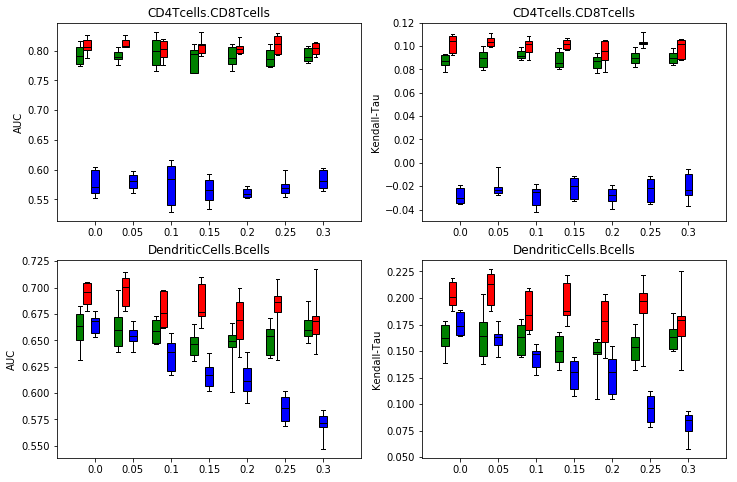

In [178]:
batch='AB'
measure_names = ['AUC','Kendall-Tau']
plt.figure(figsize=(12, 8))
for name, measure in enumerate([ 'auc', 'K']): 
    for row,comparison in enumerate(["CD4Tcells.CD8Tcells", "DendriticCells.Bcells"]):
        boxes = dict(widths=0.1, patch_artist=True, medianprops=dict(color="black"), whis=[5, 95], sym="")
        #AUC CD$CD*
        ax = plt.subplot(2, 2, row*2+name+1)
        ax.set_ylabel(measure_names[name])
        plt.title(comparison)
        bp1 = ax.boxplot([scvires['bayes_scanviAB'][comparison][prop][measure]
                          for prop in props], 
                         positions=[x*10 for x in props], **boxes)

        bp2 = ax.boxplot([scvires['bayes_AB'][comparison][prop][measure]
                  for prop in props], 
                 positions=[(x*10+0.1) for x in props], **boxes)
        
        bp3 = ax.boxplot([edgeR_res[prop][edgeR_com[comparison]][batch][measure]
                  for prop in props], 
                 positions=[(x*10+0.2) for x in props], **boxes)

        for patch in bp1['boxes']:
            patch.set_facecolor('green')
        for patch in bp2['boxes']:
            patch.set_facecolor('red')
        for patch in bp3['boxes']:
            patch.set_facecolor('blue')

        ax.set_xticklabels(props)
#         ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]] ,['scANVI', 'scVI', 'EdgeR'])

plt.savefig('PBMC.mislabelled.pdf')

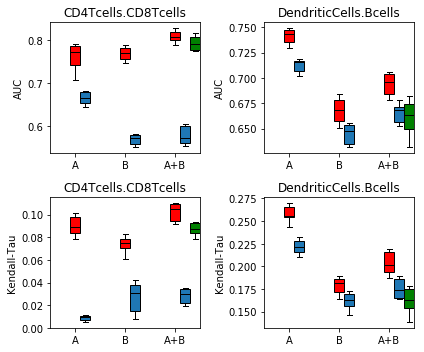

In [183]:
measure_names = ['AUC','Kendall-Tau']
plt.figure(figsize=(6, 5))
for name, measure in enumerate([ 'auc', 'K']): 
    for row,comparison in enumerate(["CD4Tcells.CD8Tcells", "DendriticCells.Bcells"]):
        props = dict(widths=0.2, patch_artist=True, medianprops=dict(color="black"), whis=[5, 95], sym="")

        #AUC CD$CD*
        ax = plt.subplot(2, 2, row+name*2+1)
        ax.set_ylabel(measure_names[name])
#         ax.set_ylabel(comparison)
        plt.title(comparison)
        bp1 = ax.boxplot([np.abs(edgeR_res[0.0][edgeR_com[comparison]][x][measure]) for x in ['A','B','AB'] ], positions=[0.2, 1.2, 2.2], **props)
        bp2 = ax.boxplot([scvires['bayes_scanviAB'][comparison][0.0][measure]], positions=[2.4], **props)
        bp3 = ax.boxplot([scvires[x][comparison][0.0][measure] for x in ['bayes_A','bayes_B','bayes_AB']], positions=[0, 1, 2], **props)

        for patch in bp3['boxes']:
            patch.set_facecolor('red')
        for patch in bp2['boxes']:
            patch.set_facecolor('green')

        ax.set_xticklabels(['A','B', 'A+B'])

# ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['edgeR', 'SCANVI', 'scVI'])
plt.tight_layout()
plt.savefig('PBMC.DE.pdf')